<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/04.04-Lunar-Lander-Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
try: 
  import control as ct
except:
  !pip install control
  import control as ct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 5.2 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=859516c7947420431c6a5385dde5ba33f09a57f0b906c5f1305fd212d71139b9
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Successfully built control


# Lunar lander dynamics

To develop a mathematical model we start with a force and torque balance for the lunar lander. Let $p_x$ be the horizontal position, $v_x$ be the horizontal speed, $p_y$ be the vertical position, $v_y$ be the vertical speed, $\theta$ be the heading, $v_{\theta}$ be the heading speed, using Newton’s second law and the free body diagram shown below, we can derive the following equations of motion:

\begin{align*}
\frac{dp_x}{dt} & = v_x \\
\frac{dv_x}{dt} & = \frac{F_l\cos(\theta) - F_t\sin(\theta)}{m_t} \\
\frac{dp_y}{dt} & = \left\{ 
  \begin{array}{ c l }
    v_y & \quad \textrm{if } p_y \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{dv_y}{dt} & = \left\{ 
  \begin{array}{ c l }
    \frac{F_l\sin(\theta) - F_t\cos(\theta)}{m_t} - g & \quad \textrm{if } p_y \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{d\theta}{dt} & = v_\theta \\
\frac{dv_\theta}{dt} & = \frac{L}{J}F_l \\
\end{align*}

and the following auxiliary equations and constraints:

\begin{align*}
c_f & = \left\{ 
  \begin{array}{ c l }
    \frac{F_t + |F_l| }{I_{sp}} & \quad \textrm{if } p_ym_f \gt 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right. \\
\frac{dm_t}{dt} & = -c_f \\
\frac{dm_f}{dt} & = -c_f \\
\end{align*}

\begin{align*}
0 \leq F_t \leq F_{t,max} \\
-F_{l,max} \leq F_l \leq F_{l,max} \\
\end{align*}

where $F_l$ is the lateral engine thurst, $F_t$ is the main engine thurst, $m_t$ is the total mass, $g$ is the moon's gravitional constant, $J$ the moment of inertia, $I_{sp}$ is the lateral and main engine specific impulse, $c_f$ is the fuel consumption and $m_f$ be the fuel mass.

The model parameters and initial conditions are given in the following tables.

\begin{array}{|c|c|c|} \hline
\textrm{Parameter} & \textrm{Value} & \textrm{Unit} \\ \hline
g & \textrm{1.6} & m/s^2 \\
L & \textrm{4.0} & m \\
J & \textrm{100,000} & kgm^2 \\
I_{sp} & 3,000 & N/(kg/s) \\
F_{t,max} & 44,000 & N \\
F_{l,max} & 500 & N \\ \hline
\end{array}

\begin{array}{|c|c|c|} \hline
\textrm{Initial condition} & \textrm{Value} & \textrm{Unit} \\ \hline
p_x & \textrm{500} & m \\
v_x & 0 & m/s \\
p_y & \textrm{160,000} & m \\
v_y & -700 & m/s \\
\theta & 0 & rad \\
v_{\theta} & 0 & rad/s \\
m_t & 15,000 & kg \\ 
m_f & 8,000 & kg \\ \hline
\end{array}

In [ ]:
def lunar_update(t, x, u, params={}):
  """Lunar lander dynamics
    Parameters
    ----------
    x: array
         System state: p_x     horizontal position [m]
                       v_x     horizontal speed    [m/s]
                       p_y     vertical position   [m]
                       v_y     vertical speed      [m/s]
                       theta   heading             [rad]
                       v_theta heading speed       [rad/s]
                       m_t     total mass          [kg]
                       m_f     fuel mass           [kg]
        
    u: array
         System input: F_t   main engine thrust    [N]
                       F_l   lateral engine thrust [N]
  
    Returns
    -------
    y: array
         The time derivatives of p_x, v_x, p_y, v_y, theta, v_theta, m_t and m_f
    """   

  # Set up the system parameters
  # Source: https://web.aeromech.usyd.edu.au/AMME3500/Course_documents/material/tutorials/Assignment%204%20Lunar%20Lander%20Solution.pdf
  g       = params.get('g',        1.6)     # moon gravitational constant   [m/s2]
  L       = params.get('L',        4.0)     # distance to center of gravity [m]
  J       = params.get('J',      100.0e+03) # moment of inertia             [kg m2]
  I_sp    = params.get('I_sp',     3.0e+03) # thruster specific impulse     [N/(kg/s)]
  F_t_max = params.get('F_t_max', 44.0e+03) # main engine max thrust        [N]
  F_l_max = params.get('F_l_max',  0.5e+03) # lateral engine max thrust     [N]

  #p_x_0   =   0.5e+03 # initial horizontal position  [m]
  #v_x_0   =   0.0e+03 # initial horizontal speed     [m/s]
  #p_y_0   = 160.0e+03 # initial vertical position    [m]
  #v_y_0   =  -0.7e+03 # initial vertical speed       [m/s]
  #theta   =   0.0e+03 # initial heading              [rad]
  #v_theta =   0.0e+03 # initial heading speed        [rad/s]
  #m_t_0   =  15.0e+03 # initial total mass           [kg]
  #m_f_0   =   8.0e+03 # initial fuel mass            [kg]

  p_x     = x[0] # horizontal position [m]
  v_x     = x[1] # horizontal speed    [m/s]
  p_y     = x[2] # vertical position   [m]
  v_y     = x[3] # vertical speed      [m/s]
  theta   = x[4] # heading             [rad]
  v_theta = x[5] # heading speed       [rad/s]
  m_t     = x[6] # total mass          [kg]
  m_f     = x[7] # fuel mass           [kg]
 
  F_t = u[0] # main engine thrust    [N]
  F_l = u[1] # lateral engine thrust [N]

  # Define the auxiliary equations
  F_t = np.clip(F_t, 0, F_t_max)
  F_l = np.clip(F_l, -F_l_max, F_l_max)
  c_f = (F_t + np.abs(F_l))/I_sp if p_y*m_f > 0 else 0

  # Define the ODEs
  p_xdot     = v_x
  v_xdot     = (F_l*np.cos(theta) - F_t*np.sin(theta))/m_t
  p_ydot     = v_y if p_y > 0 else 0
  v_ydot     = (F_l*np.sin(theta) + F_t*np.cos(theta))/m_t - g if p_y > 0 else 0
  thetadot   = v_theta
  v_thetadot = (L/J)*F_l
  m_tdot     = -c_f
  m_fdot     = -c_f
 
  return [p_xdot, v_xdot, p_ydot, v_ydot, thetadot, v_thetadot, m_tdot, m_fdot]

## Input/ouput model for the lunar lander

We now create an input/output model for the lunar lander that takes the main engine thurst $F_t$ and the lateral engine thurst $F_l$ as inputs and outputs the horizontal position $p_x$, the horizontal speed $v_x$, the vertical position $p_y$, the vertical speed $v_y$, the heading $\theta$, the heading speed $v_\theta$, the total mass $m_t$ and the fuel mass $m_f$.



In [ ]:
lunar = ct.NonlinearIOSystem(lunar_update, 
                             None, 
                             inputs  = ('F_t', 'F_l'), 
                             outputs = ('p_x', 'v_x', 'p_y', 'v_y', 'theta', 'v_theta', 'm_t', 'm_f'), 
                             states  = ('p_x', 'v_x', 'p_y', 'v_y', 'theta', 'v_theta', 'm_t', 'm_f'), 
                             name    = 'lunar')

Next we define a function for creating a "standard" landing control plot.

In [ ]:
def landing_plot(sys, T, u, x0):

  t, y = ct.input_output_response(sys, T, u, x0)

  xlabel = 'Time $t$ [s]'
  ylabel = ['Main engine thrust $F_t$ [kN]',
            'Lateral engine thrust $F_l$ [kN]',
            'Horizontal position $p_x$ [km]',
            'Horizontal speed $v_x$ [m/s]',
            'Vertical position $p_y$ [km]',
            'Vertical speed $v_y$ [m/s]',
            'Heading $\\theta$ [rad]',
            'Heading speed $v_\\theta$ [rad/s]',
            'Total mass $m_t$ [Mg]',
            'Fuel mass $m_t$ [Mg]'
            ]

  fig, axes = plt.subplots(5, 2, figsize=(22, 22))
  axe = axes.ravel()

  for k, ax in enumerate(axe):
    scale = 1e3 if k in [0,1,2,4] else 1
    if k in [0,1]:
      ax.plot(t, u[k]/scale)
    else:
      ax.plot(t, y[k-2]/scale)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel[k])
    ax.grid(True, linestyle='dotted')
  
  return t, y

Let's see what happens when the crew start only the main engine at $t=10s$.

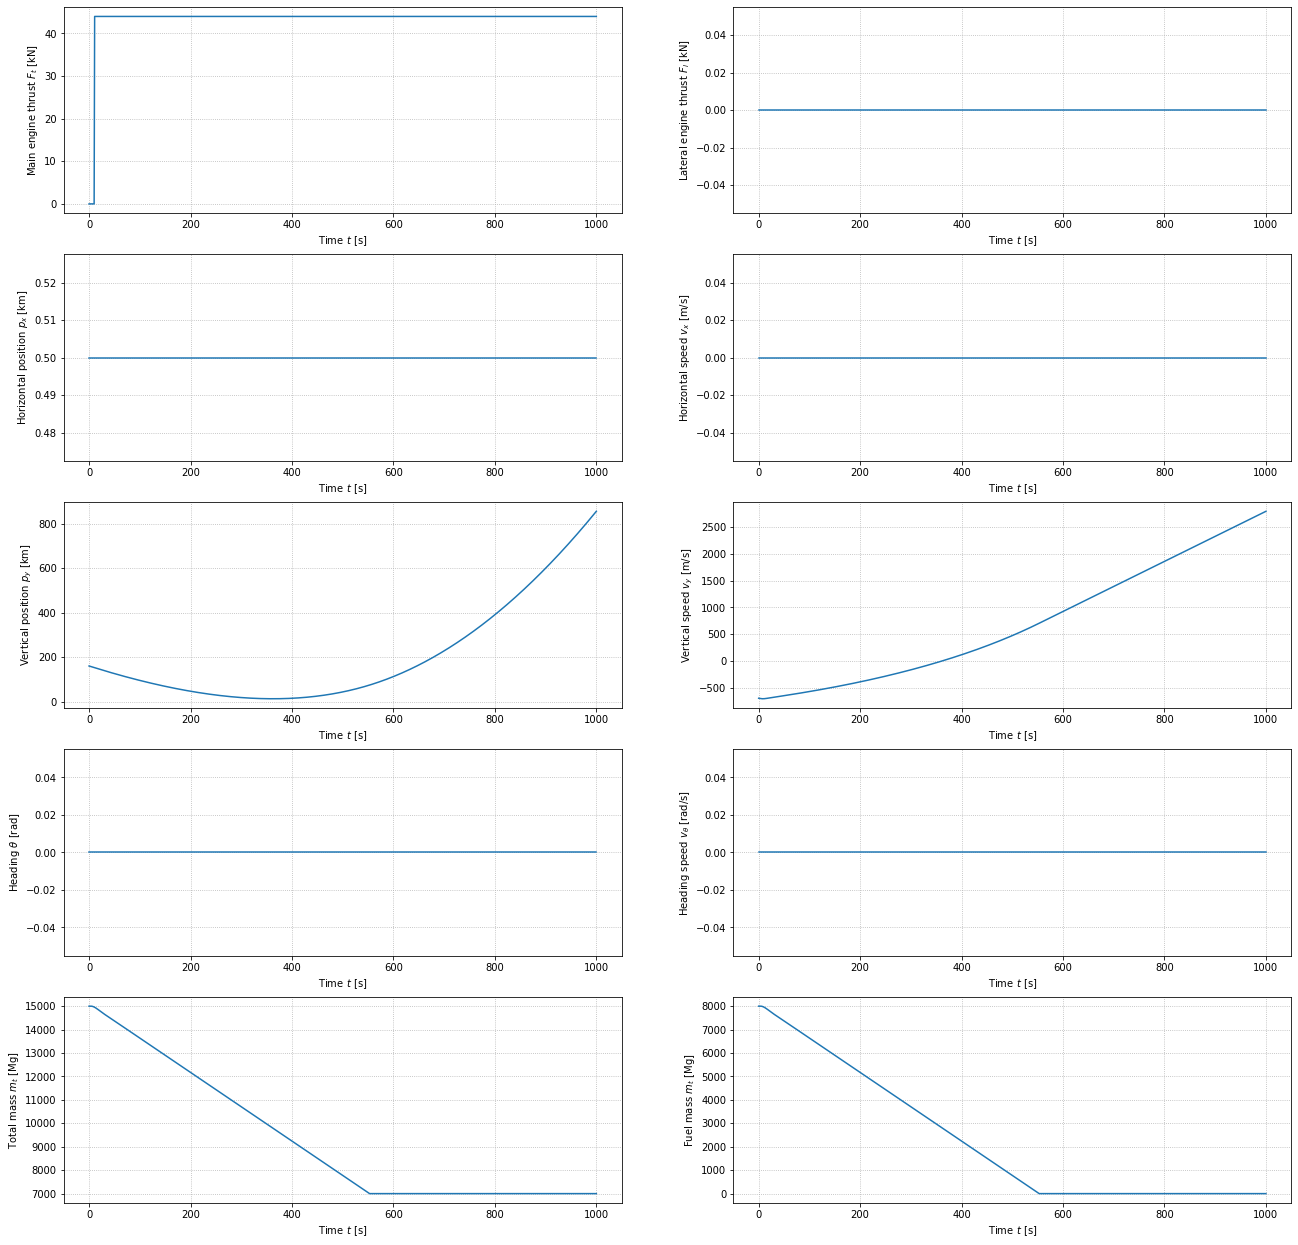

In [ ]:
# Initial conditions
X0 = [0.5e+03, 0.0, 160.0e+03, -0.7e+03, 0.0, 0.0, 15.0e+03, 8.0e+03]
# Total simulation time
tst = 1000
# Fire time
ft = 10
# Simulation time array
T  = np.linspace(0, tst, tst+1)
# Inputs
F_t  = np.array([0.0 if t <= ft else 44.0e+03 for t in T])
F_l  = np.array([0.0 for t in T])
# Simulate and plot
t, y = landing_plot(lunar, T, [F_t, F_l], X0)

The plots shown that the lunar lander loosed altitude till $p_y=12km$ and then began to accelerate out of the moon. 

At $t=1,000s$ it reached $p_y>800km$.

So, the crew was not able to land the lunar lander with this control strategy.

We will need to design some control loops to accomplish this task.